In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [ ]:
large_X_raw = np.load('drive/MyDrive/train.npy', allow_pickle=True)
large_y = pd.read_csv('drive/MyDrive/train_labels.csv')['label'].values

scaler_large = StandardScaler()
large_X = scaler_large.fit_transform(large_X_raw).T  # shape: (features, samples)

df_small = pd.read_csv('drive/MyDrive/optdigits_8x8.csv')
small_X_raw = df_small.iloc[:, :-1].values
small_y = df_small.iloc[:, -1].values

scaler_small = StandardScaler()
small_X = scaler_small.fit_transform(small_X_raw).T  # shape: (features, samples)

pca_small = PCA(n_components=0.95)
small_X_pca = pca_small.fit_transform(small_X.T)

pca_large = PCA(n_components=0.95)
large_X_pca = pca_large.fit_transform(large_X.T)

Sıfırdan

In [ ]:
class BinarySVM:
    def __init__(self, lr=0.01, lambda_param=0.01, n_iters=100):
        self.lr = lr
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            # calculate margin for all samples
            margin = y_ * (np.dot(X, self.w) + self.b)
            misclassified = margin < 1

            # gradients only from misclassified points
            dw = 2 * self.lambda_param * self.w - np.dot(X[misclassified].T, y_[misclassified]) / n_samples
            db = -np.sum(y_[misclassified]) / n_samples

            # gradient descent update
            self.w -= self.lr * dw
            self.b -= self.lr * db

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

class MultiClassSVM:
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.classifiers = {}

    def fit(self, X, y):
        self.unique_classes = np.unique(y)
        for c in self.unique_classes:
            y_binary = np.where(y == c, 1, -1)
            clf = BinarySVM(**self.kwargs)
            clf.fit(X, y_binary)
            self.classifiers[c] = clf

    def predict(self, X):
        scores = []
        for c in self.unique_classes:
            pred = np.dot(X, self.classifiers[c].w) + self.classifiers[c].b
            scores.append(pred)
        scores = np.array(scores)  # shape: (n_classes, n_samples)
        return self.unique_classes[np.argmax(scores, axis=0)]

SMALL DATASET:
Custom SVM - F1: 0.9051, Time: 0.61s
Sklearn SVM - F1: 0.9777, Time: 0.06s

LARGE DATASET:
Custom SVM - F1: 0.9796, Time: 432.63s
Sklearn SVM - F1: 0.9862, Time: 39.16s


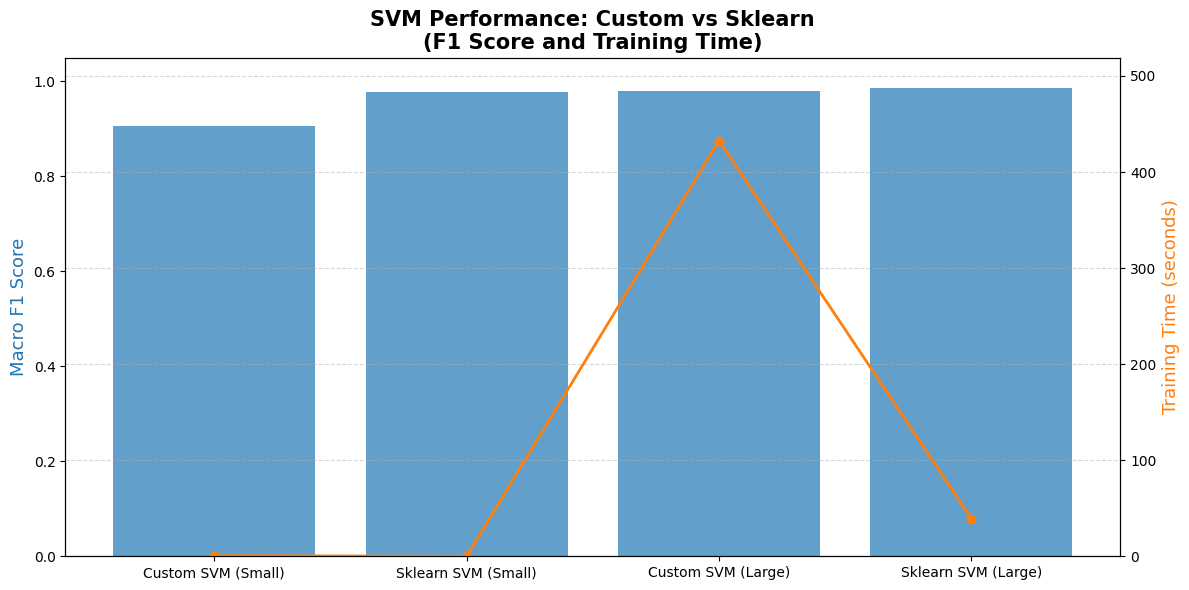

In [ ]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(small_X_pca, small_y, test_size=0.3, stratify=small_y, random_state=42)
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(large_X_pca, large_y, test_size=0.3, stratify=large_y, random_state=42)

# small dataset
# custom svm
start = time.time()
custom_s = MultiClassSVM(lr=0.001, lambda_param=0.01, n_iters=500)
custom_s.fit(X_train_s, y_train_s)
time_custom_s = time.time() - start
preds_custom_s = custom_s.predict(X_test_s)
f1_custom_s = f1_score(y_test_s, preds_custom_s, average='macro')

# sklearn svm
start = time.time()
sklearn_s = SVC(decision_function_shape='ovo')
sklearn_s.fit(X_train_s, y_train_s)
time_sklearn_s = time.time() - start
preds_sklearn_s = sklearn_s.predict(X_test_s)
f1_sklearn_s = f1_score(y_test_s, preds_sklearn_s, average='macro')

# large dataset
# custom svm
start = time.time()
custom_l = MultiClassSVM(lr=0.001, lambda_param=0.01, n_iters=500)
custom_l.fit(X_train_l, y_train_l)
time_custom_l = time.time() - start
preds_custom_l = custom_l.predict(X_test_l)
f1_custom_l = f1_score(y_test_l, preds_custom_l, average='macro')

# sklearn svm
start = time.time()
sklearn_l = SVC(decision_function_shape='ovo')
sklearn_l.fit(X_train_l, y_train_l)
time_sklearn_l = time.time() - start
preds_sklearn_l = sklearn_l.predict(X_test_l)
f1_sklearn_l = f1_score(y_test_l, preds_sklearn_l, average='macro')

print("SMALL DATASET:")
print(f"Custom SVM - F1: {f1_custom_s:.4f}, Time: {time_custom_s:.2f}s")
print(f"Sklearn SVM - F1: {f1_sklearn_s:.4f}, Time: {time_sklearn_s:.2f}s\n")

print("LARGE DATASET:")
print(f"Custom SVM - F1: {f1_custom_l:.4f}, Time: {time_custom_l:.2f}s")
print(f"Sklearn SVM - F1: {f1_sklearn_l:.4f}, Time: {time_sklearn_l:.2f}s")

labels = ['Custom SVM (Small)', 'Sklearn SVM (Small)', 'Custom SVM (Large)', 'Sklearn SVM (Large)']
f1_scores = [f1_custom_s, f1_sklearn_s, f1_custom_l, f1_sklearn_l]
times = [time_custom_s, time_sklearn_s, time_custom_l, time_sklearn_l]

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(labels, f1_scores, color='#1f77b4', alpha=0.7)
ax1.set_ylabel('Macro F1 Score', color='#1f77b4', fontsize=13)
ax1.set_ylim(0, 1.05)

ax2 = ax1.twinx()
ax2.plot(labels, times, color='#ff7f0e', marker='o', linewidth=2, label='Training Time (s)')
ax2.set_ylabel('Training Time (seconds)', color='#ff7f0e', fontsize=13)
ax2.set_ylim(0, max(times)*1.2)

plt.title('SVM Performance: Custom vs Sklearn\n(F1 Score and Training Time)', fontsize=15, weight='bold')
plt.xticks(rotation=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()